In [1]:
!nvidia-smi 

Mon Apr 20 10:13:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 31%   44C    P0    47W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 33%   40C    P0    61W / 250W |      0MiB / 11019MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
# For clean

'''import os
import fnmatch
 
INTERNAL_DATA_PATH = 'mnist_2x/'
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")'''

'import os\nimport fnmatch\n \nINTERNAL_DATA_PATH = \'mnist_2x/\'\n# Get a list of all files in directory\nfor rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):\n    # Find the files that matches the given patterm\n    for filename in fnmatch.filter(filenames, \'.*\'):\n        try:\n            #print(filename)\n            os.remove(os.path.join(rootDir, filename))\n        except OSError:\n            print("Error while deleting file")'

In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


########################################################################
batch_size = 64
########################################################################


In [4]:
DATASET_PATH = 'mnist_112'
TRAIN_PATH = DATASET_PATH + '/training'
TEST_PATH = DATASET_PATH + '/testing'

In [5]:
#img_size = [729,243,81,27,9]  

default_transform = transforms.Compose(
    [
    transforms.Resize(112),
    #transforms.Pad(28, padding_mode='constant'),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])])

trainMnistDataset = datasets.ImageFolder(root=TRAIN_PATH,transform = default_transform)
testMnistDataset = datasets.ImageFolder(root=TEST_PATH,transform = default_transform)

trainloader = torch.utils.data.DataLoader(trainMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=4)

testloader = torch.utils.data.DataLoader(testMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=False,
                                        num_workers=4)


In [6]:
testloader

TypeError: 'DataLoader' object does not support indexing

In [6]:
from SCResnet import SCResNet50

import torch.nn as nn
import torch.nn.functional as F


class Net_7(nn.Module):
    def __init__(self):
        super(Net_7, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32,10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x



In [7]:
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29501'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [8]:
device = 'cuda:2'

model1 = Net_7().to(device)
if torch.cuda.device_count() > 1:
    model1 = DDP(model1,device_ids = [2])

In [9]:
import os
from torchvision import transforms

SIZED_VAL_PATH = 'mnist_size_val/'

val_gen_arr = []
for i in tqdm(range(1,113)):
    transform = transforms.Compose(
        [
        transforms.Resize(i),
        transforms.Pad(((112-i)//2,(112-i)//2,56-i//2,56-i//2),padding_mode='constant'),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])])

    testMnistDataset_val = datasets.ImageFolder(root=SIZED_VAL_PATH,transform = transform)

    testloader_val = torch.utils.data.DataLoader(testMnistDataset_val,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=4)
    val_gen_arr.append(testloader_val)


100%|██████████| 112/112 [00:00<00:00, 313.40it/s]


In [10]:
import os
from torchvision import transforms

SIZED_VAL_PATH = 'mnist_size_val/'

val_aug_gen_arr = []
for i in tqdm(range(1,113)):
    transition_ratio = (112-i)/224
    transform = transforms.Compose(
        [
        transforms.Resize(i),
        transforms.Pad(((112-i)//2,(112-i)//2,56-i//2,56-i//2),padding_mode='constant'),
        transforms.RandomAffine(0, translate=(transition_ratio,transition_ratio),fillcolor=0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])])

    testMnistDataset_aug = datasets.ImageFolder(root=SIZED_VAL_PATH,transform = transform)

    testloader_aug = torch.utils.data.DataLoader(testMnistDataset_aug,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=4)
    val_aug_gen_arr.append(testloader_aug)



100%|██████████| 112/112 [00:00<00:00, 379.32it/s]


In [11]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

In [12]:
TEST_RESULT_PATH = 'testresults/'
WEIGHTS_PATH = 'weights/'

TASK_NAME = 'work_or_not'
DATE = 'apr19'

In [13]:
import torch.optim as optim
from tqdm import tqdm
import sys

trn_loss_list = []
val_loss_list = []
acc_list = []
acc_list_aug = []
num_batches = len(trainloader)
for epoch in range(2):
    running_loss = 0.0
    model1.train()
    for i,images in tqdm(enumerate(trainloader)):
        optimizer.zero_grad()
        c1 = images[0].to(device)
        c6 = images[1].to(device)
        output = model1(c1)
        loss = criterion(output, c6)
        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss.item()
    
    model1.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0].to(device)
            val_labels = val[1].to(device)
            val_output = model1(v1)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0
    
    temp_acc = []
    for testloader_val in tqdm(val_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader_val:
                c1 = images[0].to(device)
                val_labels = images[1].to(device)
                outputs = model1(c1)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc.append(100 * correct / total)
        #print(temp_acc)
    acc_list.append(temp_acc)
    
    temp_acc_aug = []
    for testloader_aug in tqdm(val_aug_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader_aug:
                c1 = images[0].to(device)
                val_labels = images[1].to(device)
                outputs = model1(c1)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('(AUG) Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc_aug.append(100 * correct / total)
    acc_list_aug.append(temp_acc_aug)
    
    import csv

    csvfile = open(TEST_RESULT_PATH+'testresult_'+TASK_NAME+'_'+DATE+'.csv','w',newline="")

    csvwriter = csv.writer(csvfile)
    for row in acc_list:
        csvwriter.writerow(row)

    csvfile.close()
    
    csvfile = open(TEST_RESULT_PATH+'testresult_'+TASK_NAME+'_aug_'+DATE+'.csv','w',newline="")

    csvwriter = csv.writer(csvfile)
    for row in acc_list_aug:
        csvwriter.writerow(row)

    csvfile.close()
    
    torch.save(model1.state_dict(),WEIGHTS_PATH+TASK_NAME+'_'+DATE+'.pt')
    
    if epoch == 1:
        optimizer = optim.Adam(model1.parameters(), lr=0.0001)
        print('lr is changed to 0.0001')
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)'''
    

938it [00:11, 79.24it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 83 %
Accuracy of     1 : 95 %
Accuracy of     2 : 58 %
Accuracy of     3 : 42 %
Accuracy of     4 : 79 %
Accuracy of     5 : 30 %
Accuracy of     6 : 24 %
Accuracy of     7 : 79 %
Accuracy of     8 : 72 %
Accuracy of     9 : 55 %
epoch: 1/30 | step: 10/938 | trn loss: 1.4958 | val loss: 1.0738
Accuracy of the network on the 10000 test images: 62 %


  1%|          | 1/112 [00:00<00:54,  2.03it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:55,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:54,  2.00it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:55,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:55,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:53,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:54,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:52,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:51,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:51,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:50,  2.01it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:50,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:06<00:49,  2.00it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:49,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:48,  2.01it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:48,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:08<00:47,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:47,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:09<00:48,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:10<00:47,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:10<00:46,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:11<00:45,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:11<00:44,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:12<00:44,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:12<00:44,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:13<00:44,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:13<00:43,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:14<00:43,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:14<00:42,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:15<00:41,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:15<00:41,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:16<00:40,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:16<00:40,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:17<00:40,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:17<00:40,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:18<00:40,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:18<00:39,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:19<00:38,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:19<00:39,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [00:20<00:38,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [00:21<00:37,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [00:21<00:36,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [00:22<00:35,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 39%|███▉      | 44/112 [00:22<00:35,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 40%|████      | 45/112 [00:23<00:34,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 41%|████      | 46/112 [00:23<00:33,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 42%|████▏     | 47/112 [00:24<00:32,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 43%|████▎     | 48/112 [00:24<00:32,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 44%|████▍     | 49/112 [00:25<00:31,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 45%|████▍     | 50/112 [00:25<00:31,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 46%|████▌     | 51/112 [00:26<00:31,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 46%|████▋     | 52/112 [00:26<00:30,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 47%|████▋     | 53/112 [00:27<00:30,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 48%|████▊     | 54/112 [00:27<00:29,  1.94it/s]

Accuracy of the network on the 10000 test images: 11 %


 49%|████▉     | 55/112 [00:28<00:29,  1.96it/s]

Accuracy of the network on the 10000 test images: 11 %


 50%|█████     | 56/112 [00:28<00:28,  1.95it/s]

Accuracy of the network on the 10000 test images: 12 %


 51%|█████     | 57/112 [00:29<00:28,  1.95it/s]

Accuracy of the network on the 10000 test images: 12 %


 52%|█████▏    | 58/112 [00:29<00:28,  1.90it/s]

Accuracy of the network on the 10000 test images: 13 %


 53%|█████▎    | 59/112 [00:30<00:27,  1.91it/s]

Accuracy of the network on the 10000 test images: 13 %


 54%|█████▎    | 60/112 [00:30<00:27,  1.88it/s]

Accuracy of the network on the 10000 test images: 13 %


 54%|█████▍    | 61/112 [00:31<00:26,  1.91it/s]

Accuracy of the network on the 10000 test images: 15 %


 55%|█████▌    | 62/112 [00:31<00:25,  1.93it/s]

Accuracy of the network on the 10000 test images: 15 %


 56%|█████▋    | 63/112 [00:32<00:25,  1.89it/s]

Accuracy of the network on the 10000 test images: 17 %


 57%|█████▋    | 64/112 [00:32<00:24,  1.92it/s]

Accuracy of the network on the 10000 test images: 17 %


 58%|█████▊    | 65/112 [00:33<00:24,  1.90it/s]

Accuracy of the network on the 10000 test images: 18 %


 59%|█████▉    | 66/112 [00:33<00:23,  1.93it/s]

Accuracy of the network on the 10000 test images: 19 %


 60%|█████▉    | 67/112 [00:34<00:23,  1.93it/s]

Accuracy of the network on the 10000 test images: 20 %


 61%|██████    | 68/112 [00:34<00:22,  1.94it/s]

Accuracy of the network on the 10000 test images: 20 %


 62%|██████▏   | 69/112 [00:35<00:22,  1.89it/s]

Accuracy of the network on the 10000 test images: 21 %


 62%|██████▎   | 70/112 [00:36<00:22,  1.85it/s]

Accuracy of the network on the 10000 test images: 22 %


 63%|██████▎   | 71/112 [00:36<00:21,  1.87it/s]

Accuracy of the network on the 10000 test images: 23 %


 64%|██████▍   | 72/112 [00:37<00:21,  1.90it/s]

Accuracy of the network on the 10000 test images: 24 %


 65%|██████▌   | 73/112 [00:37<00:20,  1.91it/s]

Accuracy of the network on the 10000 test images: 25 %


 66%|██████▌   | 74/112 [00:38<00:19,  1.92it/s]

Accuracy of the network on the 10000 test images: 26 %


 67%|██████▋   | 75/112 [00:38<00:19,  1.91it/s]

Accuracy of the network on the 10000 test images: 27 %


 68%|██████▊   | 76/112 [00:39<00:18,  1.90it/s]

Accuracy of the network on the 10000 test images: 28 %


 69%|██████▉   | 77/112 [00:39<00:18,  1.91it/s]

Accuracy of the network on the 10000 test images: 29 %


 70%|██████▉   | 78/112 [00:40<00:17,  1.93it/s]

Accuracy of the network on the 10000 test images: 30 %


 71%|███████   | 79/112 [00:40<00:17,  1.92it/s]

Accuracy of the network on the 10000 test images: 31 %


 71%|███████▏  | 80/112 [00:41<00:16,  1.93it/s]

Accuracy of the network on the 10000 test images: 32 %


 72%|███████▏  | 81/112 [00:41<00:16,  1.93it/s]

Accuracy of the network on the 10000 test images: 33 %


 73%|███████▎  | 82/112 [00:42<00:15,  1.93it/s]

Accuracy of the network on the 10000 test images: 35 %


 74%|███████▍  | 83/112 [00:42<00:15,  1.88it/s]

Accuracy of the network on the 10000 test images: 36 %


 75%|███████▌  | 84/112 [00:43<00:14,  1.91it/s]

Accuracy of the network on the 10000 test images: 37 %


 76%|███████▌  | 85/112 [00:43<00:14,  1.91it/s]

Accuracy of the network on the 10000 test images: 38 %


 77%|███████▋  | 86/112 [00:44<00:13,  1.88it/s]

Accuracy of the network on the 10000 test images: 39 %


 78%|███████▊  | 87/112 [00:44<00:13,  1.90it/s]

Accuracy of the network on the 10000 test images: 40 %


 79%|███████▊  | 88/112 [00:45<00:12,  1.91it/s]

Accuracy of the network on the 10000 test images: 43 %


 79%|███████▉  | 89/112 [00:46<00:12,  1.87it/s]

Accuracy of the network on the 10000 test images: 43 %


 80%|████████  | 90/112 [00:46<00:11,  1.89it/s]

Accuracy of the network on the 10000 test images: 45 %


 81%|████████▏ | 91/112 [00:47<00:11,  1.89it/s]

Accuracy of the network on the 10000 test images: 46 %


 82%|████████▏ | 92/112 [00:47<00:10,  1.89it/s]

Accuracy of the network on the 10000 test images: 48 %


 83%|████████▎ | 93/112 [00:48<00:10,  1.89it/s]

Accuracy of the network on the 10000 test images: 48 %


 84%|████████▍ | 94/112 [00:48<00:09,  1.90it/s]

Accuracy of the network on the 10000 test images: 50 %


 85%|████████▍ | 95/112 [00:49<00:09,  1.87it/s]

Accuracy of the network on the 10000 test images: 51 %


 86%|████████▌ | 96/112 [00:49<00:08,  1.87it/s]

Accuracy of the network on the 10000 test images: 53 %


 87%|████████▋ | 97/112 [00:50<00:08,  1.86it/s]

Accuracy of the network on the 10000 test images: 54 %


 88%|████████▊ | 98/112 [00:50<00:07,  1.86it/s]

Accuracy of the network on the 10000 test images: 56 %


 88%|████████▊ | 99/112 [00:51<00:07,  1.82it/s]

Accuracy of the network on the 10000 test images: 56 %


 89%|████████▉ | 100/112 [00:51<00:06,  1.86it/s]

Accuracy of the network on the 10000 test images: 58 %


 90%|█████████ | 101/112 [00:52<00:06,  1.83it/s]

Accuracy of the network on the 10000 test images: 58 %


 91%|█████████ | 102/112 [00:53<00:05,  1.85it/s]

Accuracy of the network on the 10000 test images: 59 %


 92%|█████████▏| 103/112 [00:53<00:04,  1.87it/s]

Accuracy of the network on the 10000 test images: 60 %


 93%|█████████▎| 104/112 [00:54<00:04,  1.88it/s]

Accuracy of the network on the 10000 test images: 60 %


 94%|█████████▍| 105/112 [00:54<00:03,  1.84it/s]

Accuracy of the network on the 10000 test images: 62 %


 95%|█████████▍| 106/112 [00:55<00:03,  1.85it/s]

Accuracy of the network on the 10000 test images: 62 %


 96%|█████████▌| 107/112 [00:55<00:02,  1.87it/s]

Accuracy of the network on the 10000 test images: 62 %


 96%|█████████▋| 108/112 [00:56<00:02,  1.86it/s]

Accuracy of the network on the 10000 test images: 62 %


 97%|█████████▋| 109/112 [00:56<00:01,  1.85it/s]

Accuracy of the network on the 10000 test images: 63 %


 98%|█████████▊| 110/112 [00:57<00:01,  1.89it/s]

Accuracy of the network on the 10000 test images: 64 %


 99%|█████████▉| 111/112 [00:57<00:00,  1.90it/s]

Accuracy of the network on the 10000 test images: 65 %


  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 64 %


  1%|          | 1/112 [00:00<00:54,  2.02it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:55,  1.99it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:54,  1.99it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:55,  1.94it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:55,  1.94it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:54,  1.96it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:54,  1.93it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:54,  1.91it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:53,  1.92it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:54,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:54,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:53,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:06<00:52,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:52,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:51,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:51,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:51,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:50,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:10<00:51,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:10<00:50,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:11<00:49,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:11<00:48,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:12<00:47,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:12<00:47,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:13<00:45,  1.90it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:13<00:45,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:14<00:45,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:14<00:45,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:15<00:44,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:15<00:43,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:16<00:42,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:16<00:41,  1.91it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:17<00:41,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:18<00:42,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:18<00:41,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:19<00:40,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:19<00:40,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:20<00:39,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:20<00:39,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [00:21<00:38,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [00:21<00:37,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [00:22<00:38,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [00:22<00:37,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 39%|███▉      | 44/112 [00:23<00:38,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 40%|████      | 45/112 [00:24<00:37,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 41%|████      | 46/112 [00:24<00:36,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 42%|████▏     | 47/112 [00:25<00:36,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 43%|████▎     | 48/112 [00:25<00:34,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 44%|████▍     | 49/112 [00:26<00:35,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 45%|████▍     | 50/112 [00:26<00:34,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 46%|████▌     | 51/112 [00:27<00:33,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 46%|████▋     | 52/112 [00:27<00:33,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 47%|████▋     | 53/112 [00:28<00:32,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 12 %


 48%|████▊     | 54/112 [00:29<00:31,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 49%|████▉     | 55/112 [00:29<00:31,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 12 %


 50%|█████     | 56/112 [00:30<00:30,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 12 %


 51%|█████     | 57/112 [00:30<00:29,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 12 %


 52%|█████▏    | 58/112 [00:31<00:30,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 13 %


 53%|█████▎    | 59/112 [00:31<00:29,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 13 %


 54%|█████▎    | 60/112 [00:32<00:29,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 14 %


 54%|█████▍    | 61/112 [00:32<00:28,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 14 %


 55%|█████▌    | 62/112 [00:33<00:27,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 15 %


 56%|█████▋    | 63/112 [00:33<00:26,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 16 %


 57%|█████▋    | 64/112 [00:34<00:25,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 16 %


 58%|█████▊    | 65/112 [00:35<00:25,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 17 %


 59%|█████▉    | 66/112 [00:35<00:24,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 17 %


 60%|█████▉    | 67/112 [00:36<00:24,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 19 %


 61%|██████    | 68/112 [00:36<00:23,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 19 %


 62%|██████▏   | 69/112 [00:37<00:23,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 20 %


 62%|██████▎   | 70/112 [00:37<00:23,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 20 %


 63%|██████▎   | 71/112 [00:38<00:22,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 21 %


 64%|██████▍   | 72/112 [00:38<00:21,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 22 %


 65%|██████▌   | 73/112 [00:39<00:21,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 24 %


 66%|██████▌   | 74/112 [00:39<00:20,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 24 %


 67%|██████▋   | 75/112 [00:40<00:20,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 26 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 27 %


 69%|██████▉   | 77/112 [00:41<00:19,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 27 %


 70%|██████▉   | 78/112 [00:42<00:18,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 29 %


 71%|███████   | 79/112 [00:42<00:18,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 30 %


 71%|███████▏  | 80/112 [00:43<00:17,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 32 %


 72%|███████▏  | 81/112 [00:43<00:17,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 33 %


 73%|███████▎  | 82/112 [00:44<00:16,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 34 %


 74%|███████▍  | 83/112 [00:44<00:15,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 36 %


 75%|███████▌  | 84/112 [00:45<00:15,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 36 %


 76%|███████▌  | 85/112 [00:46<00:14,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 36 %


 77%|███████▋  | 86/112 [00:46<00:14,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 38 %


 78%|███████▊  | 87/112 [00:47<00:13,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 40 %


 79%|███████▊  | 88/112 [00:47<00:13,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 40 %


 79%|███████▉  | 89/112 [00:48<00:12,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 43 %


 80%|████████  | 90/112 [00:48<00:12,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 44 %


 81%|████████▏ | 91/112 [00:49<00:11,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 46 %


 82%|████████▏ | 92/112 [00:49<00:10,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 47 %


 83%|████████▎ | 93/112 [00:50<00:10,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 49 %


 84%|████████▍ | 94/112 [00:51<00:09,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 49 %


 85%|████████▍ | 95/112 [00:51<00:09,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 51 %


 86%|████████▌ | 96/112 [00:52<00:08,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 52 %


 87%|████████▋ | 97/112 [00:52<00:08,  1.73it/s]

(AUG) Accuracy of the network on the 10000 test images: 55 %


 88%|████████▊ | 98/112 [00:53<00:07,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 56 %


 88%|████████▊ | 99/112 [00:53<00:07,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 57 %


 89%|████████▉ | 100/112 [00:54<00:06,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 58 %


 90%|█████████ | 101/112 [00:54<00:06,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 58 %


 91%|█████████ | 102/112 [00:55<00:05,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 59 %


 92%|█████████▏| 103/112 [00:56<00:05,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 60 %


 93%|█████████▎| 104/112 [00:56<00:04,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 61 %


 94%|█████████▍| 105/112 [00:57<00:03,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 62 %


 95%|█████████▍| 106/112 [00:57<00:03,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 60 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 63 %


 96%|█████████▋| 108/112 [00:58<00:02,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 63 %


 97%|█████████▋| 109/112 [00:59<00:01,  1.72it/s]

(AUG) Accuracy of the network on the 10000 test images: 63 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 63 %


 99%|█████████▉| 111/112 [01:00<00:00,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 65 %


100%|██████████| 112/112 [01:01<00:00,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 64 %



938it [00:11, 82.74it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 72 %
Accuracy of     1 : 98 %
Accuracy of     2 : 69 %
Accuracy of     3 : 47 %
Accuracy of     4 : 73 %
Accuracy of     5 : 75 %
Accuracy of     6 : 75 %
Accuracy of     7 : 87 %
Accuracy of     8 : 82 %
Accuracy of     9 : 82 %
epoch: 2/30 | step: 10/938 | trn loss: 0.9298 | val loss: 0.7369
Accuracy of the network on the 10000 test images: 76 %


  1%|          | 1/112 [00:00<00:54,  2.05it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:55,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:54,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:53,  2.01it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:52,  2.02it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:52,  2.02it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:52,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:54,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:52,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:51,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:50,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:51,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:06<00:50,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:50,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:52,  1.85it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:50,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:08<00:49,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:48,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:09<00:48,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:10<00:47,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:10<00:46,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:11<00:46,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:11<00:45,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:12<00:46,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:12<00:45,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:13<00:44,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:13<00:43,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:14<00:42,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:14<00:42,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:15<00:41,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:15<00:42,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:16<00:41,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:17<00:41,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:17<00:40,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:17<00:38,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:18<00:38,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:18<00:38,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:19<00:37,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:20<00:37,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [00:20<00:36,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [00:21<00:36,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [00:21<00:36,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [00:22<00:36,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 39%|███▉      | 44/112 [00:22<00:34,  1.95it/s]

Accuracy of the network on the 10000 test images: 11 %


 40%|████      | 45/112 [00:23<00:34,  1.94it/s]

Accuracy of the network on the 10000 test images: 11 %


 41%|████      | 46/112 [00:23<00:33,  1.95it/s]

Accuracy of the network on the 10000 test images: 12 %


 42%|████▏     | 47/112 [00:24<00:33,  1.95it/s]

Accuracy of the network on the 10000 test images: 13 %


 43%|████▎     | 48/112 [00:24<00:32,  1.95it/s]

Accuracy of the network on the 10000 test images: 14 %


 44%|████▍     | 49/112 [00:25<00:32,  1.93it/s]

Accuracy of the network on the 10000 test images: 15 %


 45%|████▍     | 50/112 [00:25<00:31,  1.94it/s]

Accuracy of the network on the 10000 test images: 16 %


 46%|████▌     | 51/112 [00:26<00:31,  1.94it/s]

Accuracy of the network on the 10000 test images: 17 %


 46%|████▋     | 52/112 [00:26<00:30,  1.94it/s]

Accuracy of the network on the 10000 test images: 18 %


 47%|████▋     | 53/112 [00:27<00:30,  1.96it/s]

Accuracy of the network on the 10000 test images: 19 %


 48%|████▊     | 54/112 [00:27<00:29,  1.96it/s]

Accuracy of the network on the 10000 test images: 20 %


 49%|████▉     | 55/112 [00:28<00:29,  1.96it/s]

Accuracy of the network on the 10000 test images: 22 %


 50%|█████     | 56/112 [00:28<00:28,  1.98it/s]

Accuracy of the network on the 10000 test images: 23 %


 51%|█████     | 57/112 [00:29<00:28,  1.95it/s]

Accuracy of the network on the 10000 test images: 23 %


 52%|█████▏    | 58/112 [00:29<00:27,  1.95it/s]

Accuracy of the network on the 10000 test images: 24 %


 53%|█████▎    | 59/112 [00:30<00:26,  1.97it/s]

Accuracy of the network on the 10000 test images: 25 %


 54%|█████▎    | 60/112 [00:30<00:26,  1.97it/s]

Accuracy of the network on the 10000 test images: 26 %


 54%|█████▍    | 61/112 [00:31<00:25,  2.00it/s]

Accuracy of the network on the 10000 test images: 27 %


 55%|█████▌    | 62/112 [00:31<00:25,  1.98it/s]

Accuracy of the network on the 10000 test images: 29 %


 56%|█████▋    | 63/112 [00:32<00:25,  1.90it/s]

Accuracy of the network on the 10000 test images: 30 %


 57%|█████▋    | 64/112 [00:32<00:25,  1.87it/s]

Accuracy of the network on the 10000 test images: 30 %


 58%|█████▊    | 65/112 [00:33<00:24,  1.88it/s]

Accuracy of the network on the 10000 test images: 32 %


 59%|█████▉    | 66/112 [00:33<00:24,  1.91it/s]

Accuracy of the network on the 10000 test images: 33 %


 60%|█████▉    | 67/112 [00:34<00:23,  1.94it/s]

Accuracy of the network on the 10000 test images: 35 %


 61%|██████    | 68/112 [00:34<00:22,  1.97it/s]

Accuracy of the network on the 10000 test images: 36 %


 62%|██████▏   | 69/112 [00:35<00:21,  1.96it/s]

Accuracy of the network on the 10000 test images: 37 %


 62%|██████▎   | 70/112 [00:36<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 38 %


 63%|██████▎   | 71/112 [00:36<00:21,  1.87it/s]

Accuracy of the network on the 10000 test images: 40 %


 64%|██████▍   | 72/112 [00:37<00:21,  1.88it/s]

Accuracy of the network on the 10000 test images: 42 %


 65%|██████▌   | 73/112 [00:37<00:20,  1.87it/s]

Accuracy of the network on the 10000 test images: 42 %


 66%|██████▌   | 74/112 [00:38<00:20,  1.89it/s]

Accuracy of the network on the 10000 test images: 44 %


 67%|██████▋   | 75/112 [00:38<00:20,  1.82it/s]

Accuracy of the network on the 10000 test images: 44 %


 68%|██████▊   | 76/112 [00:39<00:19,  1.84it/s]

Accuracy of the network on the 10000 test images: 45 %


 69%|██████▉   | 77/112 [00:39<00:19,  1.83it/s]

Accuracy of the network on the 10000 test images: 47 %


 70%|██████▉   | 78/112 [00:40<00:18,  1.84it/s]

Accuracy of the network on the 10000 test images: 48 %


 71%|███████   | 79/112 [00:40<00:17,  1.88it/s]

Accuracy of the network on the 10000 test images: 50 %


 71%|███████▏  | 80/112 [00:41<00:17,  1.87it/s]

Accuracy of the network on the 10000 test images: 50 %


 72%|███████▏  | 81/112 [00:41<00:16,  1.90it/s]

Accuracy of the network on the 10000 test images: 51 %


 73%|███████▎  | 82/112 [00:42<00:15,  1.90it/s]

Accuracy of the network on the 10000 test images: 52 %


 74%|███████▍  | 83/112 [00:43<00:15,  1.84it/s]

Accuracy of the network on the 10000 test images: 53 %


 75%|███████▌  | 84/112 [00:43<00:15,  1.80it/s]

Accuracy of the network on the 10000 test images: 54 %


 76%|███████▌  | 85/112 [00:44<00:14,  1.80it/s]

Accuracy of the network on the 10000 test images: 55 %


 77%|███████▋  | 86/112 [00:44<00:14,  1.85it/s]

Accuracy of the network on the 10000 test images: 56 %


 78%|███████▊  | 87/112 [00:45<00:13,  1.84it/s]

Accuracy of the network on the 10000 test images: 57 %


 79%|███████▊  | 88/112 [00:45<00:12,  1.85it/s]

Accuracy of the network on the 10000 test images: 58 %


 79%|███████▉  | 89/112 [00:46<00:12,  1.81it/s]

Accuracy of the network on the 10000 test images: 57 %


 80%|████████  | 90/112 [00:46<00:12,  1.79it/s]

Accuracy of the network on the 10000 test images: 59 %


 81%|████████▏ | 91/112 [00:47<00:11,  1.85it/s]

Accuracy of the network on the 10000 test images: 59 %


 82%|████████▏ | 92/112 [00:47<00:10,  1.85it/s]

Accuracy of the network on the 10000 test images: 60 %


 83%|████████▎ | 93/112 [00:48<00:10,  1.85it/s]

Accuracy of the network on the 10000 test images: 59 %


 84%|████████▍ | 94/112 [00:49<00:09,  1.88it/s]

Accuracy of the network on the 10000 test images: 62 %


 85%|████████▍ | 95/112 [00:49<00:09,  1.87it/s]

Accuracy of the network on the 10000 test images: 63 %


 86%|████████▌ | 96/112 [00:50<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 64 %


 87%|████████▋ | 97/112 [00:50<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 65 %


 88%|████████▊ | 98/112 [00:51<00:07,  1.86it/s]

Accuracy of the network on the 10000 test images: 65 %


 88%|████████▊ | 99/112 [00:51<00:06,  1.90it/s]

Accuracy of the network on the 10000 test images: 65 %


 89%|████████▉ | 100/112 [00:52<00:06,  1.91it/s]

Accuracy of the network on the 10000 test images: 65 %


 90%|█████████ | 101/112 [00:52<00:05,  1.90it/s]

Accuracy of the network on the 10000 test images: 65 %


 91%|█████████ | 102/112 [00:53<00:05,  1.89it/s]

Accuracy of the network on the 10000 test images: 66 %


 92%|█████████▏| 103/112 [00:53<00:04,  1.87it/s]

Accuracy of the network on the 10000 test images: 66 %


 93%|█████████▎| 104/112 [00:54<00:04,  1.83it/s]

Accuracy of the network on the 10000 test images: 67 %


 94%|█████████▍| 105/112 [00:54<00:03,  1.80it/s]

Accuracy of the network on the 10000 test images: 68 %


 95%|█████████▍| 106/112 [00:55<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 70 %


 96%|█████████▌| 107/112 [00:56<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 71 %


 96%|█████████▋| 108/112 [00:56<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 73 %


 97%|█████████▋| 109/112 [00:57<00:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 75 %


 98%|█████████▊| 110/112 [00:57<00:01,  1.81it/s]

Accuracy of the network on the 10000 test images: 76 %


 99%|█████████▉| 111/112 [00:58<00:00,  1.83it/s]

Accuracy of the network on the 10000 test images: 77 %


  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 77 %


  1%|          | 1/112 [00:00<00:56,  1.96it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:57,  1.92it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:57,  1.90it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:56,  1.93it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:55,  1.93it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:55,  1.92it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:54,  1.92it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:53,  1.93it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:53,  1.93it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:53,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:53,  1.90it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:53,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:06<00:53,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:51,  1.90it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:50,  1.93it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:52,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:51,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:51,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:10<00:52,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:10<00:50,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:11<00:49,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:11<00:47,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:12<00:47,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:12<00:46,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:13<00:46,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:13<00:45,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:14<00:45,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:14<00:44,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:15<00:45,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:16<00:44,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:16<00:43,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:17<00:42,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:17<00:42,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:18<00:41,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:18<00:40,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:19<00:42,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:19<00:41,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:20<00:40,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:20<00:40,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [00:21<00:39,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [00:22<00:39,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [00:22<00:39,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [00:23<00:37,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 39%|███▉      | 44/112 [00:23<00:36,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 40%|████      | 45/112 [00:24<00:36,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 41%|████      | 46/112 [00:24<00:35,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 13 %


 42%|████▏     | 47/112 [00:25<00:34,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 13 %


 43%|████▎     | 48/112 [00:25<00:34,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 14 %


 44%|████▍     | 49/112 [00:26<00:33,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 16 %


 45%|████▍     | 50/112 [00:26<00:33,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 16 %


 46%|████▌     | 51/112 [00:27<00:32,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 16 %


 46%|████▋     | 52/112 [00:27<00:32,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 17 %


 47%|████▋     | 53/112 [00:28<00:32,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 18 %


 48%|████▊     | 54/112 [00:29<00:31,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 19 %


 49%|████▉     | 55/112 [00:29<00:31,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 20 %


 50%|█████     | 56/112 [00:30<00:31,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 22 %


 51%|█████     | 57/112 [00:30<00:30,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 22 %


 52%|█████▏    | 58/112 [00:31<00:30,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 24 %


 53%|█████▎    | 59/112 [00:31<00:28,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 25 %


 54%|█████▎    | 60/112 [00:32<00:28,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 26 %


 54%|█████▍    | 61/112 [00:32<00:27,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 27 %


 55%|█████▌    | 62/112 [00:33<00:27,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 28 %


 56%|█████▋    | 63/112 [00:34<00:27,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 29 %


 57%|█████▋    | 64/112 [00:34<00:26,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 31 %


 58%|█████▊    | 65/112 [00:35<00:25,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 31 %


 59%|█████▉    | 66/112 [00:35<00:24,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 33 %


 60%|█████▉    | 67/112 [00:36<00:24,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 34 %


 61%|██████    | 68/112 [00:36<00:23,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 36 %


 62%|██████▏   | 69/112 [00:37<00:23,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 37 %


 62%|██████▎   | 70/112 [00:37<00:23,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 39 %


 63%|██████▎   | 71/112 [00:38<00:22,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 40 %


 64%|██████▍   | 72/112 [00:38<00:21,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 40 %


 65%|██████▌   | 73/112 [00:39<00:21,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 43 %


 66%|██████▌   | 74/112 [00:40<00:20,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 44 %


 67%|██████▋   | 75/112 [00:40<00:20,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 46 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 45 %


 69%|██████▉   | 77/112 [00:41<00:19,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 47 %


 70%|██████▉   | 78/112 [00:42<00:18,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 49 %


 71%|███████   | 79/112 [00:42<00:18,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 50 %


 71%|███████▏  | 80/112 [00:43<00:18,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 49 %


 72%|███████▏  | 81/112 [00:43<00:17,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 51 %


 73%|███████▎  | 82/112 [00:44<00:16,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 53 %


 74%|███████▍  | 83/112 [00:45<00:16,  1.73it/s]

(AUG) Accuracy of the network on the 10000 test images: 53 %


 75%|███████▌  | 84/112 [00:45<00:15,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 54 %


 76%|███████▌  | 85/112 [00:46<00:14,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 55 %


 77%|███████▋  | 86/112 [00:46<00:14,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 55 %


 78%|███████▊  | 87/112 [00:47<00:14,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 57 %


 79%|███████▊  | 88/112 [00:47<00:13,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 57 %


 79%|███████▉  | 89/112 [00:48<00:12,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 57 %


 80%|████████  | 90/112 [00:48<00:12,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 57 %


 81%|████████▏ | 91/112 [00:49<00:11,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 59 %


 82%|████████▏ | 92/112 [00:50<00:11,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 59 %


 83%|████████▎ | 93/112 [00:50<00:10,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 61 %


 84%|████████▍ | 94/112 [00:51<00:10,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 59 %


 85%|████████▍ | 95/112 [00:51<00:09,  1.73it/s]

(AUG) Accuracy of the network on the 10000 test images: 63 %


 86%|████████▌ | 96/112 [00:52<00:09,  1.73it/s]

(AUG) Accuracy of the network on the 10000 test images: 62 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.69it/s]

(AUG) Accuracy of the network on the 10000 test images: 64 %


 88%|████████▊ | 98/112 [00:53<00:08,  1.71it/s]

(AUG) Accuracy of the network on the 10000 test images: 65 %


 88%|████████▊ | 99/112 [00:54<00:07,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 64 %


 89%|████████▉ | 100/112 [00:54<00:06,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 66 %


 90%|█████████ | 101/112 [00:55<00:06,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 67 %


 91%|█████████ | 102/112 [00:55<00:05,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 67 %


 92%|█████████▏| 103/112 [00:56<00:04,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 68 %


 93%|█████████▎| 104/112 [00:56<00:04,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 68 %


 94%|█████████▍| 105/112 [00:57<00:03,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 70 %


 95%|█████████▍| 106/112 [00:58<00:03,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 70 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 72 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 73 %


 97%|█████████▋| 109/112 [00:59<00:01,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 73 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 74 %


 99%|█████████▉| 111/112 [01:00<00:00,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 77 %


100%|██████████| 112/112 [01:01<00:00,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 77 %
lr is changed to 0.0001


# TRAIN AND TEST ENDS

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

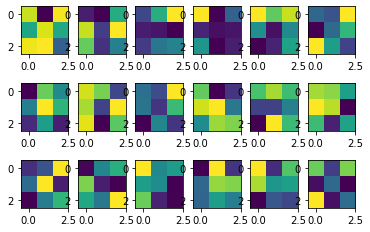

In [22]:
temp = model1.module.conv1.weight.data
for i in range(3):
    for j in range(6):
        plt.subplot(3,6,i*6+j+1)
        plt.imshow(temp.cpu().detach().numpy()[j][i])
plt.show()

In [23]:
temp.cpu().detach().transpose(0,1).shape

torch.Size([3, 6, 3, 3])

In [24]:
temp3 = F.interpolate(temp, size=(5,5), scale_factor=None, mode='bicubic', align_corners=None)

/nfs/home/hama2386/.local/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


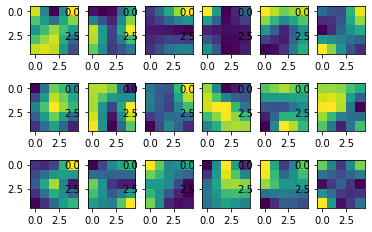

In [25]:
for i in range(3):
    for j in range(6):
        plt.subplot(3,6,i*6+j+1)
        plt.imshow(temp3.cpu().detach().numpy()[j][i])
plt.show()

In [26]:
class Net_5(nn.Module):
    def __init__(self):
        super(Net_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 7)
        self.conv3 = nn.Conv2d(16, 32, 7)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(32,10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

model2 = Net_5().to(device)
if torch.cuda.device_count() > 1:
    model2 = DDP(model2,device_ids = [2])
    
temptemp1 = model2.module.conv1.weight.data
    
model2.module.conv1.weight.data = F.interpolate(model1.module.conv1.weight.data, size=(7,7), scale_factor=None, mode='bicubic', align_corners=None)
model2.module.conv2.weight.data = model1.module.conv2.weight.data#F.interpolate(model1.module.conv2.weight.data, size=(5,5), scale_factor=None, mode='nearest', align_corners=None)
model2.module.conv3.weight.data = model1.module.conv3.weight.data#F.interpolate(model1.module.conv3.weight.data, size=(5,5), scale_factor=None, mode='nearest', align_corners=None)
model2.module.fc.weight.data = model1.module.fc.weight.data

temptemp2 = model2.module.conv1.weight.data

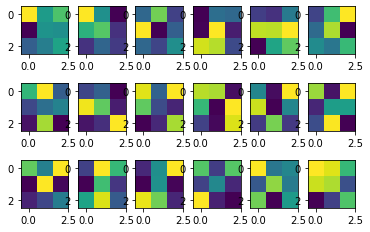

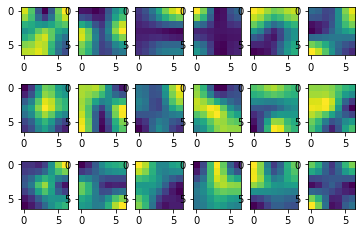

In [27]:
for i in range(3):
    for j in range(6):
        plt.subplot(3,6,i*6+j+1)
        plt.imshow(temptemp1.cpu().detach().numpy()[j][i])
plt.show()

for i in range(3):
    for j in range(6):
        plt.subplot(3,6,i*6+j+1)
        plt.imshow(temptemp2.cpu().detach().numpy()[j][i])
plt.show()

In [28]:
model2.eval()
with torch.no_grad(): # very very very very important!!!
    val_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    correct = 0
    total = 0
    for j,val in enumerate(testloader):
        v1 = val[0].to(device)
        val_labels = val[1].to(device)
        val_output = model2(v1)
        v_loss = criterion(val_output, val_labels)
        val_loss += v_loss
        _, predicted = torch.max(val_output, 1)
        c = (predicted == val_labels).squeeze()
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()
        for i in range(len(val_labels)):
            val_label = val_labels[i]
            class_correct[val_label] += c[i].item()
            class_total[val_label] += 1

    for i in range(10):
        if class_total[i]==0:
            print('class_total = 0',class_correct,class_total)
        else:
            print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
    epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
))        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

trn_loss_list.append(running_loss/1875)
val_loss_list.append(val_loss/len(testloader))
running_loss = 0.0

temp_acc = []
for testloader_val in tqdm(val_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images in testloader_val:
            c1 = images[0].to(device)
            val_labels = images[1].to(device)
            outputs = model2(c1)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    #print(total,correct,end='')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    temp_acc.append(100 * correct / total)
    #print(temp_acc)
acc_list.append(temp_acc)

temp_acc_aug = []
for testloader_aug in tqdm(val_aug_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images in testloader_aug:
            c1 = images[0].to(device)
            val_labels = images[1].to(device)
            outputs = model2(c1)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    #print(total,correct,end='')

    print('(AUG) Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    temp_acc_aug.append(100 * correct / total)
acc_list_aug.append(temp_acc_aug)

  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 88 %
Accuracy of     1 : 97 %
Accuracy of     2 : 37 %
Accuracy of     3 : 37 %
Accuracy of     4 : 65 %
Accuracy of     5 : 63 %
Accuracy of     6 : 66 %
Accuracy of     7 : 88 %
Accuracy of     8 : 75 %
Accuracy of     9 : 82 %
epoch: 2/30 | step: 10/938 | trn loss: 0.0000 | val loss: 2.3949
Accuracy of the network on the 10000 test images: 70 %


  1%|          | 1/112 [00:00<00:56,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:57,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:56,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:55,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:54,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:54,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:54,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:53,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:53,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:53,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:53,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:52,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:06<00:51,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:51,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:51,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:49,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:08<00:49,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:49,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:09<00:49,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:10<00:48,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:10<00:46,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:11<00:46,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:11<00:46,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:12<00:45,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:13<00:45,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:13<00:44,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:14<00:44,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:14<00:45,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:15<00:44,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:15<00:42,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:16<00:43,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:16<00:42,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:17<00:42,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:17<00:42,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:18<00:41,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:18<00:40,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:19<00:39,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:19<00:38,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:20<00:37,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [00:20<00:37,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [00:21<00:37,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [00:22<00:36,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [00:22<00:36,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 39%|███▉      | 44/112 [00:23<00:35,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 40%|████      | 45/112 [00:23<00:35,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 41%|████      | 46/112 [00:24<00:34,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 42%|████▏     | 47/112 [00:24<00:34,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 43%|████▎     | 48/112 [00:25<00:34,  1.86it/s]

Accuracy of the network on the 10000 test images: 11 %


 44%|████▍     | 49/112 [00:25<00:34,  1.84it/s]

Accuracy of the network on the 10000 test images: 12 %


 45%|████▍     | 50/112 [00:26<00:33,  1.87it/s]

Accuracy of the network on the 10000 test images: 12 %


 46%|████▌     | 51/112 [00:26<00:32,  1.88it/s]

Accuracy of the network on the 10000 test images: 13 %


 46%|████▋     | 52/112 [00:27<00:31,  1.89it/s]

Accuracy of the network on the 10000 test images: 14 %


 47%|████▋     | 53/112 [00:27<00:31,  1.87it/s]

Accuracy of the network on the 10000 test images: 16 %


 48%|████▊     | 54/112 [00:28<00:30,  1.92it/s]

Accuracy of the network on the 10000 test images: 16 %


 49%|████▉     | 55/112 [00:28<00:29,  1.92it/s]

Accuracy of the network on the 10000 test images: 18 %


 50%|█████     | 56/112 [00:29<00:29,  1.93it/s]

Accuracy of the network on the 10000 test images: 19 %


 51%|█████     | 57/112 [00:29<00:29,  1.88it/s]

Accuracy of the network on the 10000 test images: 20 %


 52%|█████▏    | 58/112 [00:30<00:29,  1.84it/s]

Accuracy of the network on the 10000 test images: 21 %


 53%|█████▎    | 59/112 [00:31<00:28,  1.84it/s]

Accuracy of the network on the 10000 test images: 22 %


 54%|█████▎    | 60/112 [00:31<00:28,  1.86it/s]

Accuracy of the network on the 10000 test images: 24 %


 54%|█████▍    | 61/112 [00:32<00:27,  1.85it/s]

Accuracy of the network on the 10000 test images: 24 %


 55%|█████▌    | 62/112 [00:32<00:26,  1.86it/s]

Accuracy of the network on the 10000 test images: 25 %


 56%|█████▋    | 63/112 [00:33<00:26,  1.86it/s]

Accuracy of the network on the 10000 test images: 26 %


 57%|█████▋    | 64/112 [00:33<00:25,  1.91it/s]

Accuracy of the network on the 10000 test images: 27 %


 58%|█████▊    | 65/112 [00:34<00:24,  1.91it/s]

Accuracy of the network on the 10000 test images: 28 %


 59%|█████▉    | 66/112 [00:34<00:24,  1.91it/s]

Accuracy of the network on the 10000 test images: 29 %


 60%|█████▉    | 67/112 [00:35<00:23,  1.90it/s]

Accuracy of the network on the 10000 test images: 30 %


 61%|██████    | 68/112 [00:35<00:23,  1.85it/s]

Accuracy of the network on the 10000 test images: 31 %


 62%|██████▏   | 69/112 [00:36<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 32 %


 62%|██████▎   | 70/112 [00:36<00:23,  1.82it/s]

Accuracy of the network on the 10000 test images: 35 %


 63%|██████▎   | 71/112 [00:37<00:22,  1.79it/s]

Accuracy of the network on the 10000 test images: 36 %


 64%|██████▍   | 72/112 [00:38<00:22,  1.77it/s]

Accuracy of the network on the 10000 test images: 38 %


 65%|██████▌   | 73/112 [00:38<00:21,  1.81it/s]

Accuracy of the network on the 10000 test images: 40 %


 66%|██████▌   | 74/112 [00:39<00:21,  1.78it/s]

Accuracy of the network on the 10000 test images: 42 %


 67%|██████▋   | 75/112 [00:39<00:20,  1.79it/s]

Accuracy of the network on the 10000 test images: 44 %


 68%|██████▊   | 76/112 [00:40<00:20,  1.79it/s]

Accuracy of the network on the 10000 test images: 45 %


 69%|██████▉   | 77/112 [00:40<00:19,  1.82it/s]

Accuracy of the network on the 10000 test images: 47 %


 70%|██████▉   | 78/112 [00:41<00:18,  1.81it/s]

Accuracy of the network on the 10000 test images: 49 %


 71%|███████   | 79/112 [00:41<00:17,  1.83it/s]

Accuracy of the network on the 10000 test images: 51 %


 71%|███████▏  | 80/112 [00:42<00:17,  1.86it/s]

Accuracy of the network on the 10000 test images: 52 %


 72%|███████▏  | 81/112 [00:42<00:16,  1.87it/s]

Accuracy of the network on the 10000 test images: 53 %


 73%|███████▎  | 82/112 [00:43<00:15,  1.88it/s]

Accuracy of the network on the 10000 test images: 54 %


 74%|███████▍  | 83/112 [00:44<00:15,  1.84it/s]

Accuracy of the network on the 10000 test images: 55 %


 75%|███████▌  | 84/112 [00:44<00:15,  1.85it/s]

Accuracy of the network on the 10000 test images: 56 %


 76%|███████▌  | 85/112 [00:45<00:14,  1.87it/s]

Accuracy of the network on the 10000 test images: 57 %


 77%|███████▋  | 86/112 [00:45<00:14,  1.77it/s]

Accuracy of the network on the 10000 test images: 59 %


 78%|███████▊  | 87/112 [00:46<00:14,  1.78it/s]

Accuracy of the network on the 10000 test images: 60 %


 79%|███████▊  | 88/112 [00:46<00:13,  1.80it/s]

Accuracy of the network on the 10000 test images: 62 %


 79%|███████▉  | 89/112 [00:47<00:12,  1.83it/s]

Accuracy of the network on the 10000 test images: 63 %


 80%|████████  | 90/112 [00:47<00:12,  1.79it/s]

Accuracy of the network on the 10000 test images: 65 %


 81%|████████▏ | 91/112 [00:48<00:11,  1.80it/s]

Accuracy of the network on the 10000 test images: 66 %


 82%|████████▏ | 92/112 [00:49<00:11,  1.73it/s]

Accuracy of the network on the 10000 test images: 68 %


 83%|████████▎ | 93/112 [00:49<00:10,  1.76it/s]

Accuracy of the network on the 10000 test images: 68 %


 84%|████████▍ | 94/112 [00:50<00:10,  1.75it/s]

Accuracy of the network on the 10000 test images: 70 %


 85%|████████▍ | 95/112 [00:50<00:09,  1.77it/s]

Accuracy of the network on the 10000 test images: 71 %


 86%|████████▌ | 96/112 [00:51<00:08,  1.81it/s]

Accuracy of the network on the 10000 test images: 72 %


 87%|████████▋ | 97/112 [00:51<00:08,  1.82it/s]

Accuracy of the network on the 10000 test images: 72 %


 88%|████████▊ | 98/112 [00:52<00:07,  1.82it/s]

Accuracy of the network on the 10000 test images: 74 %


 88%|████████▊ | 99/112 [00:52<00:07,  1.82it/s]

Accuracy of the network on the 10000 test images: 74 %


 89%|████████▉ | 100/112 [00:53<00:06,  1.83it/s]

Accuracy of the network on the 10000 test images: 73 %


 90%|█████████ | 101/112 [00:54<00:06,  1.79it/s]

Accuracy of the network on the 10000 test images: 76 %


 91%|█████████ | 102/112 [00:54<00:05,  1.80it/s]

Accuracy of the network on the 10000 test images: 73 %


 92%|█████████▏| 103/112 [00:55<00:04,  1.83it/s]

Accuracy of the network on the 10000 test images: 75 %


 93%|█████████▎| 104/112 [00:55<00:04,  1.82it/s]

Accuracy of the network on the 10000 test images: 74 %


 94%|█████████▍| 105/112 [00:56<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 75 %


 95%|█████████▍| 106/112 [00:56<00:03,  1.80it/s]

Accuracy of the network on the 10000 test images: 73 %


 96%|█████████▌| 107/112 [00:57<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 75 %


 96%|█████████▋| 108/112 [00:58<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 72 %


 97%|█████████▋| 109/112 [00:58<00:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 73 %


 98%|█████████▊| 110/112 [00:59<00:01,  1.76it/s]

Accuracy of the network on the 10000 test images: 72 %


 99%|█████████▉| 111/112 [00:59<00:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 72 %


  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 71 %


  1%|          | 1/112 [00:00<00:59,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:58,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:58,  1.86it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:59,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:57,  1.85it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:57,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:57,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:58,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:58,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:56,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<00:54,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:54,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:07<00:54,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:52,  1.87it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:08<00:51,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:50,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:50,  1.89it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:50,  1.88it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:10<00:51,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:10<00:49,  1.84it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 19%|█▉        | 21/112 [00:11<00:50,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:12<00:49,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:12<00:49,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:13<00:48,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:13<00:49,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:14<00:48,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:14<00:46,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:15<00:46,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:15<00:45,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 27%|██▋       | 30/112 [00:16<00:46,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:17<00:46,  1.72it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 29%|██▊       | 32/112 [00:17<00:45,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 29%|██▉       | 33/112 [00:18<00:44,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 30%|███       | 34/112 [00:18<00:43,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 31%|███▏      | 35/112 [00:19<00:42,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 32%|███▏      | 36/112 [00:19<00:42,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 33%|███▎      | 37/112 [00:20<00:41,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 34%|███▍      | 38/112 [00:20<00:41,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 35%|███▍      | 39/112 [00:21<00:40,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 36%|███▌      | 40/112 [00:22<00:39,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 37%|███▋      | 41/112 [00:22<00:39,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 42/112 [00:23<00:38,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 38%|███▊      | 43/112 [00:23<00:38,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 39%|███▉      | 44/112 [00:24<00:38,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 40%|████      | 45/112 [00:24<00:37,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 41%|████      | 46/112 [00:25<00:37,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 42%|████▏     | 47/112 [00:26<00:37,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 43%|████▎     | 48/112 [00:26<00:36,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 44%|████▍     | 49/112 [00:27<00:35,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 10 %


 45%|████▍     | 50/112 [00:27<00:35,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 11 %


 46%|████▌     | 51/112 [00:28<00:34,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 12 %


 46%|████▋     | 52/112 [00:28<00:33,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 13 %


 47%|████▋     | 53/112 [00:29<00:32,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 13 %


 48%|████▊     | 54/112 [00:29<00:32,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 15 %


 49%|████▉     | 55/112 [00:30<00:31,  1.83it/s]

(AUG) Accuracy of the network on the 10000 test images: 15 %


 50%|█████     | 56/112 [00:31<00:31,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 17 %


 51%|█████     | 57/112 [00:31<00:30,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 18 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 18 %


 53%|█████▎    | 59/112 [00:32<00:29,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 20 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 21 %


 54%|█████▍    | 61/112 [00:33<00:29,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 22 %


 55%|█████▌    | 62/112 [00:34<00:28,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 22 %


 56%|█████▋    | 63/112 [00:34<00:27,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 23 %


 57%|█████▋    | 64/112 [00:35<00:27,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 25 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 26 %


 59%|█████▉    | 66/112 [00:36<00:25,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 27 %


 60%|█████▉    | 67/112 [00:37<00:26,  1.73it/s]

(AUG) Accuracy of the network on the 10000 test images: 28 %


 61%|██████    | 68/112 [00:37<00:24,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 30 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 30 %


 62%|██████▎   | 70/112 [00:38<00:23,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 33 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 34 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 35 %


 65%|██████▌   | 73/112 [00:40<00:21,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 37 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 37 %


 67%|██████▋   | 75/112 [00:41<00:20,  1.82it/s]

(AUG) Accuracy of the network on the 10000 test images: 40 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 40 %


 69%|██████▉   | 77/112 [00:42<00:19,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 44 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 45 %


 71%|███████   | 79/112 [00:44<00:18,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 47 %


 71%|███████▏  | 80/112 [00:44<00:18,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 46 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 48 %


 73%|███████▎  | 82/112 [00:45<00:16,  1.79it/s]

(AUG) Accuracy of the network on the 10000 test images: 48 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.80it/s]

(AUG) Accuracy of the network on the 10000 test images: 51 %


 75%|███████▌  | 84/112 [00:46<00:15,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 52 %


 76%|███████▌  | 85/112 [00:47<00:14,  1.81it/s]

(AUG) Accuracy of the network on the 10000 test images: 52 %


 77%|███████▋  | 86/112 [00:47<00:14,  1.78it/s]

(AUG) Accuracy of the network on the 10000 test images: 55 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 55 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 56 %


 79%|███████▉  | 89/112 [00:49<00:13,  1.72it/s]

(AUG) Accuracy of the network on the 10000 test images: 57 %


 80%|████████  | 90/112 [00:50<00:12,  1.72it/s]

(AUG) Accuracy of the network on the 10000 test images: 59 %


 81%|████████▏ | 91/112 [00:50<00:11,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 60 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 63 %


 83%|████████▎ | 93/112 [00:51<00:10,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 65 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 64 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 66 %


 86%|████████▌ | 96/112 [00:53<00:09,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 66 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.74it/s]

(AUG) Accuracy of the network on the 10000 test images: 68 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.76it/s]

(AUG) Accuracy of the network on the 10000 test images: 68 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.75it/s]

(AUG) Accuracy of the network on the 10000 test images: 69 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.72it/s]

(AUG) Accuracy of the network on the 10000 test images: 70 %


 90%|█████████ | 101/112 [00:56<00:06,  1.68it/s]

(AUG) Accuracy of the network on the 10000 test images: 71 %


 91%|█████████ | 102/112 [00:57<00:05,  1.67it/s]

(AUG) Accuracy of the network on the 10000 test images: 72 %


 92%|█████████▏| 103/112 [00:57<00:05,  1.69it/s]

(AUG) Accuracy of the network on the 10000 test images: 71 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.70it/s]

(AUG) Accuracy of the network on the 10000 test images: 70 %


 94%|█████████▍| 105/112 [00:58<00:04,  1.73it/s]

(AUG) Accuracy of the network on the 10000 test images: 73 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.68it/s]

(AUG) Accuracy of the network on the 10000 test images: 72 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.69it/s]

(AUG) Accuracy of the network on the 10000 test images: 73 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.65it/s]

(AUG) Accuracy of the network on the 10000 test images: 73 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.66it/s]

(AUG) Accuracy of the network on the 10000 test images: 73 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.68it/s]

(AUG) Accuracy of the network on the 10000 test images: 72 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.71it/s]

(AUG) Accuracy of the network on the 10000 test images: 72 %


100%|██████████| 112/112 [01:03<00:00,  1.77it/s]

(AUG) Accuracy of the network on the 10000 test images: 71 %
